# i. Perkenalan

**FINAL PROJECT TEAM 2**

Anggota    :
- Alwan Abdurrahman 
- Berliana Fitria Dewi 
- Muhammad Fakhrian Abimanyu 
- Ryandino 
- Satriya Fauzan Adhim

Program ini dibuat untuk melakukan proses machine learning dari persiapan data hingga model deployment. Adapun data yang digunakan adalah data yang telah dilakukan cleaning secara otomatis dengan airflow.


## Background


Evaluasi kinerja rumah sakit sangat penting untuk memastikan kualitas layanan yang diberikan tetap tinggi dan sesuai dengan kebutuhan pasien. Namun, evaluasi yang dilakukan setelah data terkumpul sering kali tidak cukup untuk pengambilan keputusan yang cepat dan tepat. Oleh karena itu, dibutuhkan indeks performa rumah sakit untuk menjadi satu nilai yang dapat mewakili performa rumah sakit tersebut. Penggunaan model machine learning untuk memprediksi indeks performa rumah sakit di bulan berikutnya menjadi solusi yang inovatif. Model ini akan menggunakan data seperti jumlah pasien, tingkat kepuasan pasien, dan pendapatan rata-rata untuk mendapatkan nilai indeks performa yang kemudian dapat digunakan untuk memberikan prediksi yang akurat. Dengan prediksi ini, rumah sakit dapat mengelola sumber daya dengan lebih baik, meningkatkan kepuasan pasien, dan merencanakan keuangan secara lebih efektif. Implementasi model ini diharapkan dapat membantu manajemen rumah sakit untuk lebih sadar akan kualitas layanan yang diberikan serta dapat mengambil tindakan yang lebih cepat dan tepat guna meningkatkan kualitas layanan secara keseluruhan.

# ii. Import Library


In [1]:
pip install feature-engine xgboost lightgbm phik seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
import joblib


from feature_engine.outliers import Winsorizer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from phik import phik_matrix

import warnings
import joblib

warnings.filterwarnings('ignore')


# iii. Data Loading

In [3]:
data = pd.read_csv("cleaned_data.csv")

In [4]:
data.head()

,id_trx,date_in,date_out,drug_qty,admin_price,cogs,Durasi_Rawat,hospital_care,infusion_cost,room_type,...,drug_type,drug_price,branch_name,patient_name,gender,age,payment_name,review_name,revenue,profit
0,37677,2020-12-15,2020-12-16,1,50000,10444564,2,Rawat Inap,165000,Kelas 1,...,Vitamin,110000,RSMS,"Marsudi Sihombing, M.M.",Laki-laki,47,Asuransi,Tidak Puas,9810000.0,-634564.0
1,38835,2021-02-18,2021-02-18,5,50000,4161459,1,Rawat Jalan,0,NaN,...,Umum,40000,RSMS,"Uli Yuniar, S.E.I",Perempuan,74,Pribadi,Netral,640000.0,-3521459.0
2,11321,2020-08-09,2020-08-09,4,50000,2140822,1,Rawat Jalan,0,NaN,...,Umum,40000,RSMS,Asmianto Suwarno,Laki-laki,63,Pribadi,Netral,590000.0,-1550822.0
3,64426,2021-03-14,2021-03-14,3,50000,4772100,1,Rawat Jalan,0,NaN,...,Umum,40000,RSMA,R. Kasiyah Fujiati,Perempuan,23,Pribadi,Netral,550000.0,-4222100.0
4,58351,2022-02-22,2022-02-22,1,50000,2750711,1,Rawat Jalan,0,NaN,...,Antibiotik,75000,RSMS,Upik Pratiwi,Perempuan,30,Pribadi,Netral,525000.0,-2225711.0


## 3.1 Mengecek missing data pada dataset

In [5]:
# Memeriksa missing data
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum() / data.isnull().count() * 100).sort_values(ascending=False)
missing_data_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data_df.head(20)

,Total,Percent
surgery_type,3573,37.713743
lab_name,1620,17.099430
room_type,1573,16.603335
surgery_price,0,0.000000
revenue,0,0.000000
review_name,0,0.000000
payment_name,0,0.000000
age,0,0.000000
gender,0,0.000000
patient_name,0,0.000000


In [6]:
# Menghitung total baris yang memiliki setidaknya satu nilai yang hilang
total_rows_with_missing = data.isnull().any(axis=1).sum()

print("Total baris dengan missing value:", total_rows_with_missing)


Total baris dengan missing value: 4581


Setelah dilakukan pengecekan terhadap missing data yang terdapat dalam data, data yang tidak ada merupakan baris data yang memang tidak memerlukan data tersebut. Sehingga tidak diperlukan adanya penanganan terhadap missing values yang ada.

## 3.2 Mengecek Duplikasi Data pada data train

In [7]:
data.duplicated().sum()

0

Tidak terdapat duplikasi pada dataset.

In [8]:
dfeda = data
dfeda

,id_trx,date_in,date_out,drug_qty,admin_price,cogs,Durasi_Rawat,hospital_care,infusion_cost,room_type,...,drug_type,drug_price,branch_name,patient_name,gender,age,payment_name,review_name,revenue,profit
0,37677,2020-12-15,2020-12-16,1,50000,10444564,2,Rawat Inap,165000,Kelas 1,...,Vitamin,110000,RSMS,"Marsudi Sihombing, M.M.",Laki-laki,47,Asuransi,Tidak Puas,9810000.0,-634564.0
1,38835,2021-02-18,2021-02-18,5,50000,4161459,1,Rawat Jalan,0,NaN,...,Umum,40000,RSMS,"Uli Yuniar, S.E.I",Perempuan,74,Pribadi,Netral,640000.0,-3521459.0
2,11321,2020-08-09,2020-08-09,4,50000,2140822,1,Rawat Jalan,0,NaN,...,Umum,40000,RSMS,Asmianto Suwarno,Laki-laki,63,Pribadi,Netral,590000.0,-1550822.0
3,64426,2021-03-14,2021-03-14,3,50000,4772100,1,Rawat Jalan,0,NaN,...,Umum,40000,RSMA,R. Kasiyah Fujiati,Perempuan,23,Pribadi,Netral,550000.0,-4222100.0
4,58351,2022-02-22,2022-02-22,1,50000,2750711,1,Rawat Jalan,0,NaN,...,Antibiotik,75000,RSMS,Upik Pratiwi,Perempuan,30,Pribadi,Netral,525000.0,-2225711.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9469,97526,2021-06-02,2021-06-07,4,50000,5845529,6,Rawat Inap,165000,Kelas 3,...,Vitamin,110000,RSMD,Luwar Wahyuni,Laki-laki,65,Pribadi,Tidak Puas,8075000.0,2229471.0
9470,96420,2021-06-18,2021-06-23,2,50000,10834302,6,Rawat Inap,165000,Kelas 2,...,Vitamin,110000,RSMS,"Tgk. Ulya Manullang, M.Pd",Laki-laki,64,Pribadi,Tidak Puas,12940000.0,2105698.0
9471,70578,2023-12-08,2023-12-11,3,50000,6395598,4,Rawat Inap,165000,Kelas 1,...,Umum,40000,RSMD,"Dt. Carub Wibisono, M.Pd",Laki-laki,21,Pribadi,Tidak Puas,7550000.0,1154402.0
9472,36008,2023-01-07,2023-01-07,2,50000,2469846,1,Rawat Jalan,0,NaN,...,Umum,40000,RSMA,Wulan Mustofa,Perempuan,69,Pribadi,Tidak Puas,625000.0,-1844846.0


In [9]:
dfeda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9474 entries, 0 to 9473
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id_trx         9474 non-null   int64  
 1   date_in        9474 non-null   object 
 2   date_out       9474 non-null   object 
 3   drug_qty       9474 non-null   int64  
 4   admin_price    9474 non-null   int64  
 5   cogs           9474 non-null   int64  
 6   Durasi_Rawat   9474 non-null   int64  
 7   hospital_care  9474 non-null   object 
 8   infusion_cost  9474 non-null   int64  
 9   room_type      7901 non-null   object 
 10  room_price     9474 non-null   float64
 11  food_price     9474 non-null   float64
 12  doctor_type    9474 non-null   object 
 13  doctor_price   9474 non-null   int64  
 14  surgery_type   5901 non-null   object 
 15  surgery_price  9474 non-null   float64
 16  lab_name       7854 non-null   object 
 17  lab_price      9474 non-null   float64
 18  drug_bra

In [10]:
print (dfeda)

      id_trx     date_in    date_out  drug_qty  admin_price      cogs  \
0      37677  2020-12-15  2020-12-16         1        50000  10444564   
1      38835  2021-02-18  2021-02-18         5        50000   4161459   
2      11321  2020-08-09  2020-08-09         4        50000   2140822   
3      64426  2021-03-14  2021-03-14         3        50000   4772100   
4      58351  2022-02-22  2022-02-22         1        50000   2750711   
...      ...         ...         ...       ...          ...       ...   
9469   97526  2021-06-02  2021-06-07         4        50000   5845529   
9470   96420  2021-06-18  2021-06-23         2        50000  10834302   
9471   70578  2023-12-08  2023-12-11         3        50000   6395598   
9472   36008  2023-01-07  2023-01-07         2        50000   2469846   
9473   55083  2020-08-07  2020-08-12         2        50000  10080630   

      Durasi_Rawat hospital_care  infusion_cost room_type  ...   drug_type  \
0                2    Rawat Inap         1650

## 3.3 Pre Processing Data

In [12]:
# Mengonversi kolom date_out menjadi tipe data datetime
dfeda['date_out'] = pd.to_datetime(dfeda['date_out'])

# Menambahkan kolom bulan dan tahun
dfeda['month'] = dfeda['date_out'].dt.month
dfeda['year'] = dfeda['date_out'].dt.year

# Memetakan nilai-nilai review ke skala yang diinginkan
review_mapping = {
    'Sangat Tidak Puas': 1,
    'Tidak Puas': 2,
    'Cukup Puas': 3,
    'Puas': 4,
    'Sangat Puas': 5
}
dfeda['review_value'] = dfeda['review_name'].map(review_mapping)
dfeda['name_gender_age'] = dfeda['patient_name'] + '_' + dfeda['gender'] + '_' + dfeda['age'].astype(str)
# Mengelompokkan dan menghitung total_pasien, total_revenue, dan total_profit
new_df = dfeda.groupby(['branch_name', 'month', 'year']).agg(
    jumlah_pasien=('name_gender_age', 'nunique'),
    avg_review=('review_value', 'mean'),
    cogs=('cogs', 'sum'),
    total_revenue=('revenue', 'sum'),
    total_profit=('profit', 'sum')
).reset_index()

new_df

,branch_name,month,year,jumlah_pasien,avg_review,cogs,total_revenue,total_profit
0,RSMA,1,2020,73,2.925926,618794664,704880000.0,86085336.0
1,RSMA,1,2021,70,3.137255,577144399,620665000.0,43520601.0
2,RSMA,1,2022,78,2.929577,573240080,621825000.0,48584920.0
3,RSMA,1,2023,54,3.000000,391419494,440955000.0,49535506.0
4,RSMA,1,2024,6,3.000000,56732879,70240000.0,13507121.0
...,...,...,...,...,...,...,...,...
142,RSMS,11,2023,59,2.791667,409660260,433070000.0,23409740.0
143,RSMS,12,2020,57,3.269231,520486164,579870000.0,59383836.0
144,RSMS,12,2021,66,3.125000,479313670,512980000.0,33666330.0
145,RSMS,12,2022,69,3.266667,456831916,471050000.0,14218084.0


In [13]:
# Inisialisasi MinMaxScaler
scaler = MinMaxScaler()

# Menghitung nilai minimum dan maksimum dari jumlah_pasien
min_value = new_df['jumlah_pasien'].min()
max_value = new_df['jumlah_pasien'].max()

# Normalisasi nilai jumlah_pasien
new_df['norm_jumlah_pasien'] = scaler.fit_transform(new_df[['jumlah_pasien']])

# Menampilkan dataframe baru
new_df

,branch_name,month,year,jumlah_pasien,avg_review,cogs,total_revenue,total_profit,norm_jumlah_pasien
0,RSMA,1,2020,73,2.925926,618794664,704880000.0,86085336.0,0.8375
1,RSMA,1,2021,70,3.137255,577144399,620665000.0,43520601.0,0.8000
2,RSMA,1,2022,78,2.929577,573240080,621825000.0,48584920.0,0.9000
3,RSMA,1,2023,54,3.000000,391419494,440955000.0,49535506.0,0.6000
4,RSMA,1,2024,6,3.000000,56732879,70240000.0,13507121.0,0.0000
...,...,...,...,...,...,...,...,...,...
142,RSMS,11,2023,59,2.791667,409660260,433070000.0,23409740.0,0.6625
143,RSMS,12,2020,57,3.269231,520486164,579870000.0,59383836.0,0.6375
144,RSMS,12,2021,66,3.125000,479313670,512980000.0,33666330.0,0.7500
145,RSMS,12,2022,69,3.266667,456831916,471050000.0,14218084.0,0.7875


In [14]:
# Menghitung nilai minimum dan maksimum dari total_profit
min_value = new_df['total_profit'].min()
max_value = new_df['total_profit'].max()

# Normalisasi nilai total_profit
new_df['norm_total_profit'] = scaler.fit_transform(new_df[['total_profit']])

# Menampilkan dataframe baru
print(new_df)

    branch_name  month  year  jumlah_pasien  avg_review       cogs  \
0          RSMA      1  2020             73    2.925926  618794664   
1          RSMA      1  2021             70    3.137255  577144399   
2          RSMA      1  2022             78    2.929577  573240080   
3          RSMA      1  2023             54    3.000000  391419494   
4          RSMA      1  2024              6    3.000000   56732879   
..          ...    ...   ...            ...         ...        ...   
142        RSMS     11  2023             59    2.791667  409660260   
143        RSMS     12  2020             57    3.269231  520486164   
144        RSMS     12  2021             66    3.125000  479313670   
145        RSMS     12  2022             69    3.266667  456831916   
146        RSMS     12  2023             79    2.983051  603039152   

     total_revenue  total_profit  norm_jumlah_pasien  norm_total_profit  
0      704880000.0    86085336.0              0.8375           0.710629  
1      6206

In [15]:
# Menghitung nilai minimum dan maksimum dari avg_review
min_value = new_df['avg_review'].min()
max_value = new_df['avg_review'].max()

# Normalisasi nilai avg_review
new_df['norm_avg_review'] = scaler.fit_transform(new_df[['avg_review']])

# Menampilkan dataframe baru
new_df

,branch_name,month,year,jumlah_pasien,avg_review,cogs,total_revenue,total_profit,norm_jumlah_pasien,norm_total_profit,norm_avg_review
0,RSMA,1,2020,73,2.925926,618794664,704880000.0,86085336.0,0.8375,0.710629,0.429302
1,RSMA,1,2021,70,3.137255,577144399,620665000.0,43520601.0,0.8000,0.331874,0.610415
2,RSMA,1,2022,78,2.929577,573240080,621825000.0,48584920.0,0.9000,0.376938,0.432432
3,RSMA,1,2023,54,3.000000,391419494,440955000.0,49535506.0,0.6000,0.385397,0.492785
4,RSMA,1,2024,6,3.000000,56732879,70240000.0,13507121.0,0.0000,0.064805,0.492785
...,...,...,...,...,...,...,...,...,...,...,...
142,RSMS,11,2023,59,2.791667,409660260,433070000.0,23409740.0,0.6625,0.152921,0.314240
143,RSMS,12,2020,57,3.269231,520486164,579870000.0,59383836.0,0.6375,0.473030,0.723521
144,RSMS,12,2021,66,3.125000,479313670,512980000.0,33666330.0,0.7500,0.244188,0.599913
145,RSMS,12,2022,69,3.266667,456831916,471050000.0,14218084.0,0.7875,0.071131,0.721323


In [91]:
print_df=new_df[['jumlah_pasien','avg_review','total_revenue','total_profit']]
print_df.to_csv("new.csv",index=False)

#### Menghitung skor indeks performa

In [16]:
new_df['score'] = (new_df['norm_jumlah_pasien']*0.2) + (new_df['norm_total_profit']*0.45) + (new_df['norm_avg_review']*0.35)
# new_df.drop(columns=['norm_jumlah_pasien', 'norm_total_profit','norm_avg_review'], inplace=True)
new_df

,branch_name,month,year,jumlah_pasien,avg_review,cogs,total_revenue,total_profit,norm_jumlah_pasien,norm_total_profit,norm_avg_review,score
0,RSMA,1,2020,73,2.925926,618794664,704880000.0,86085336.0,0.8375,0.710629,0.429302,0.637539
1,RSMA,1,2021,70,3.137255,577144399,620665000.0,43520601.0,0.8000,0.331874,0.610415,0.522989
2,RSMA,1,2022,78,2.929577,573240080,621825000.0,48584920.0,0.9000,0.376938,0.432432,0.500973
3,RSMA,1,2023,54,3.000000,391419494,440955000.0,49535506.0,0.6000,0.385397,0.492785,0.465903
4,RSMA,1,2024,6,3.000000,56732879,70240000.0,13507121.0,0.0000,0.064805,0.492785,0.201637
...,...,...,...,...,...,...,...,...,...,...,...,...
142,RSMS,11,2023,59,2.791667,409660260,433070000.0,23409740.0,0.6625,0.152921,0.314240,0.311299
143,RSMS,12,2020,57,3.269231,520486164,579870000.0,59383836.0,0.6375,0.473030,0.723521,0.593596
144,RSMS,12,2021,66,3.125000,479313670,512980000.0,33666330.0,0.7500,0.244188,0.599913,0.469854
145,RSMS,12,2022,69,3.266667,456831916,471050000.0,14218084.0,0.7875,0.071131,0.721323,0.441972


# iv. Exploratory Data Analysis (EDA)

### Correlation


In [18]:
cols = ['branch_name', 'month', 'year', 'jumlah_pasien', 'avg_review', 'cogs', 'total_revenue', 'total_profit', 'score']

# Menghitung matriks korelasi Phik
correlation_matrix = new_df[cols].phik_matrix(interval_cols=['month', 'year', 'jumlah_pasien', 'avg_review', 'cogs', 'total_revenue', 'total_profit', 'score'])

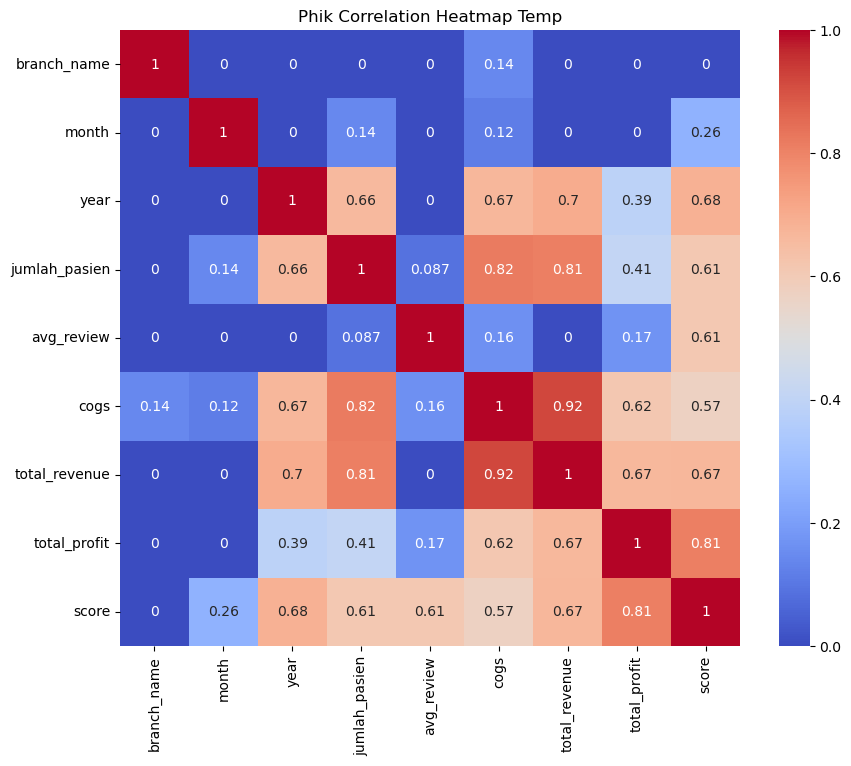

In [19]:
# Create heatmap from correlation_matrix temp
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Phik Correlation Heatmap Temp')
plt.show()

# v. Feature Engineering

## 5.1 Splitting between X and Y

In [20]:
dfml= new_df
dfml.drop(columns=['norm_jumlah_pasien', 'norm_total_profit','norm_avg_review'], inplace=True)

In [21]:
# Defining X and y
X = dfml.drop(['score'],axis=1)
y = pd.DataFrame(dfml['score'])

In [22]:
dfml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   branch_name    147 non-null    object 
 1   month          147 non-null    int32  
 2   year           147 non-null    int32  
 3   jumlah_pasien  147 non-null    int64  
 4   avg_review     147 non-null    float64
 5   cogs           147 non-null    int64  
 6   total_revenue  147 non-null    float64
 7   total_profit   147 non-null    float64
 8   score          147 non-null    float64
dtypes: float64(4), int32(2), int64(2), object(1)
memory usage: 9.3+ KB


In [23]:
# Split between Train-Set,and Test-Set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Train Size : ', X_train.shape)
print('Test Size : ', X_test.shape)

Train Size :  (117, 8)
Test Size :  (30, 8)


In [24]:
X_train

,branch_name,month,year,jumlah_pasien,avg_review,cogs,total_revenue,total_profit
135,RSMS,10,2020,66,3.214286,462088640,517825000.0,55736360.0
45,RSMA,12,2020,51,2.463415,380526058,398825000.0,18298942.0
119,RSMS,6,2020,74,3.105263,593502653,709735000.0,116232347.0
27,RSMA,7,2022,56,3.219512,469456419,513930000.0,44473581.0
4,RSMA,1,2024,6,3.000000,56732879,70240000.0,13507121.0
...,...,...,...,...,...,...,...,...
71,RSMD,6,2021,79,2.722222,692494898,811100000.0,118605102.0
106,RSMS,2,2023,69,2.865385,546862400,587060000.0,40197600.0
14,RSMA,4,2021,61,3.372549,446501827,511605000.0,65103173.0
92,RSMD,11,2022,67,3.157895,439332455,490790000.0,51457545.0


## 5.2 Scaling and Encoding

In [25]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117 entries, 135 to 102
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   branch_name    117 non-null    object 
 1   month          117 non-null    int32  
 2   year           117 non-null    int32  
 3   jumlah_pasien  117 non-null    int64  
 4   avg_review     117 non-null    float64
 5   cogs           117 non-null    int64  
 6   total_revenue  117 non-null    float64
 7   total_profit   117 non-null    float64
dtypes: float64(3), int32(2), int64(2), object(1)
memory usage: 7.3+ KB


In [26]:
# Mengidentifikasi fitur numerik dan kategori
numeric_features = ['month', 'year', 'jumlah_pasien', 'avg_review', 'cogs', 'total_revenue', 'total_profit']
categorical_features = ['branch_name']

In [27]:
# Membuat transformer untuk fitur numerik dan kategori
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

#### Encoding

In [28]:
# Apply OneHotEncoding pada fitur kategori di train set
X_train_encoded = pd.DataFrame(categorical_transformer.fit_transform(X_train[categorical_features]).toarray(),
                               columns=categorical_transformer.get_feature_names_out(categorical_features))


In [29]:
X_test_encoded = pd.DataFrame(categorical_transformer.transform(X_test[categorical_features]).toarray(),
                              columns=categorical_transformer.get_feature_names_out(categorical_features))

#### Scaling

In [30]:
# Apply Standard Scaling pada fitur numerik di train set
X_train[numeric_features] = numeric_transformer.fit_transform(X_train[numeric_features])

# Gunakan parameter yang di-fit dari train set untuk transformasi test set
X_test[numeric_features] = numeric_transformer.transform(X_test[numeric_features])


In [31]:
# Menggabungkan kembali data yang telah di-encode dengan data numerik yang telah di-scale
X_train = X_train.reset_index(drop=True)
X_train = pd.concat([X_train[numeric_features], X_train_encoded.reset_index(drop=True)], axis=1)

X_test = X_test.reset_index(drop=True)
X_test = pd.concat([X_test[numeric_features], X_test_encoded.reset_index(drop=True)], axis=1)


In [32]:
# Melihat hasil transformasi
print(X_train.head())
print(X_test.head())

      month      year  jumlah_pasien  avg_review      cogs  total_revenue  \
0  0.978970 -1.280009       0.130249    1.024197 -0.253426      -0.239086   
1  1.528321 -1.280009      -1.072841   -2.293182 -1.028426      -1.223222   
2 -0.119730 -1.280009       0.771897    0.542531  0.995256       1.348019   
3  0.154945  0.393299      -0.671811    1.047288 -0.183418      -0.271298   
4 -1.493106  2.066607      -4.682112    0.077474 -4.105075      -3.940637   

   total_profit  branch_name_RSMA  branch_name_RSMD  branch_name_RSMS  
0     -0.095764               0.0               0.0               1.0  
1     -1.697188               1.0               0.0               0.0  
2      2.492014               0.0               0.0               1.0  
3     -0.577541               1.0               0.0               0.0  
4     -1.902163               1.0               0.0               0.0  
      month      year  jumlah_pasien  avg_review      cogs  total_revenue  \
0  0.154945  0.393299       

## 5.3 Data Distribution

In [33]:
def diagnostic_plots(dfml, variable):
    # Define figure size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(dfml[variable], bins=20)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=dfml[variable])
    plt.title('Boxplot')

    plt.show()

def find_normal_boundaries(dfml, var):
    upper_boundary = dfml[var].mean() + 3 * dfml[var].std()
    lower_boundary = dfml[var].mean() - 3 * dfml[var].std()

    return upper_boundary, lower_boundary

def percentage_outlier(dfml, var, upper_boundary, lower_boundary):
    outlier_right_tail = (len(dfml[dfml[var] > upper_boundary]) / len(dfml) * 100)
    outlier_left_tail = (len(dfml[dfml[var] < lower_boundary]) / len(dfml) * 100)
    return outlier_right_tail, outlier_left_tail



Variable: month


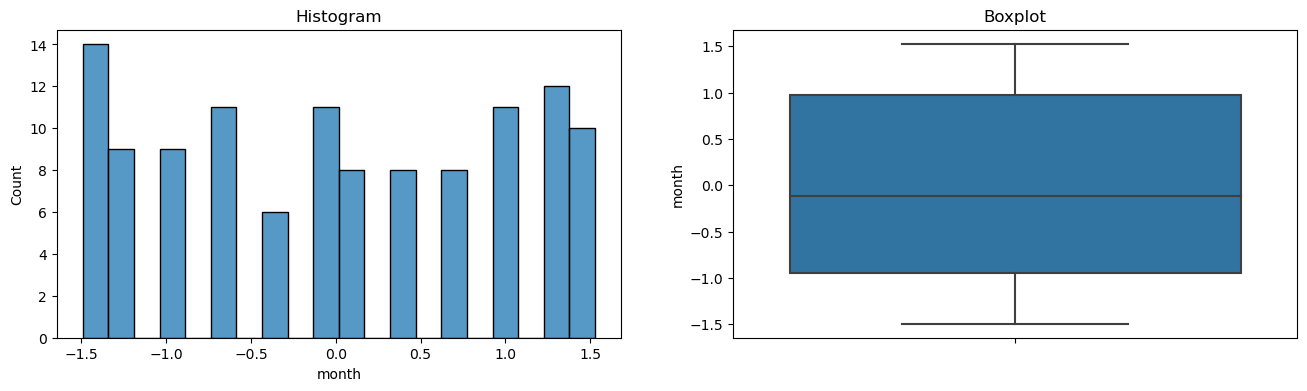

Skewness Value: -0.00872379028998767
Upper Boundary: 3.0129032853539366
Lower Boundary: -3.0129032853539366
% right end outliers: 0.0
% left end outliers: 0.0
Normal Distribution
--------------------

Variable: year


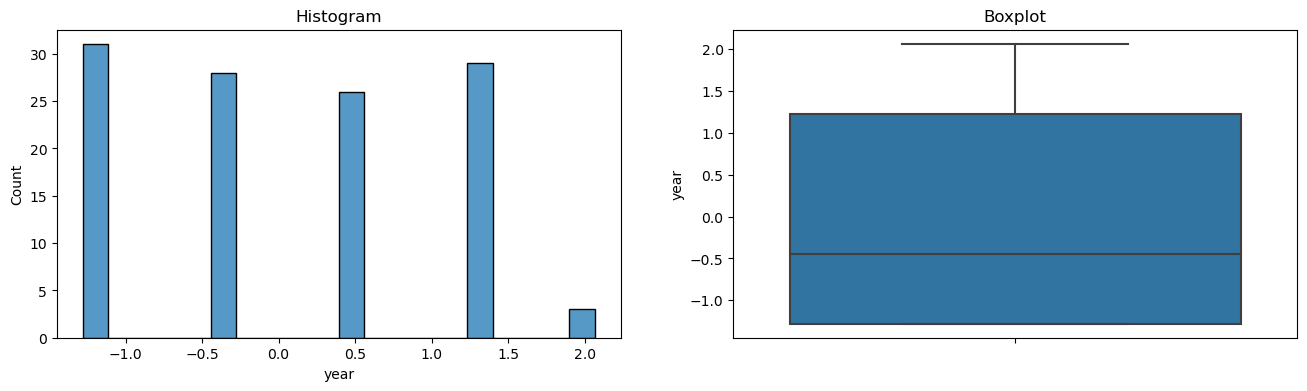

Skewness Value: 0.1261189486755841
Upper Boundary: 3.0129032853539224
Lower Boundary: -3.0129032853539552
% right end outliers: 0.0
% left end outliers: 0.0
Normal Distribution
--------------------

Variable: jumlah_pasien


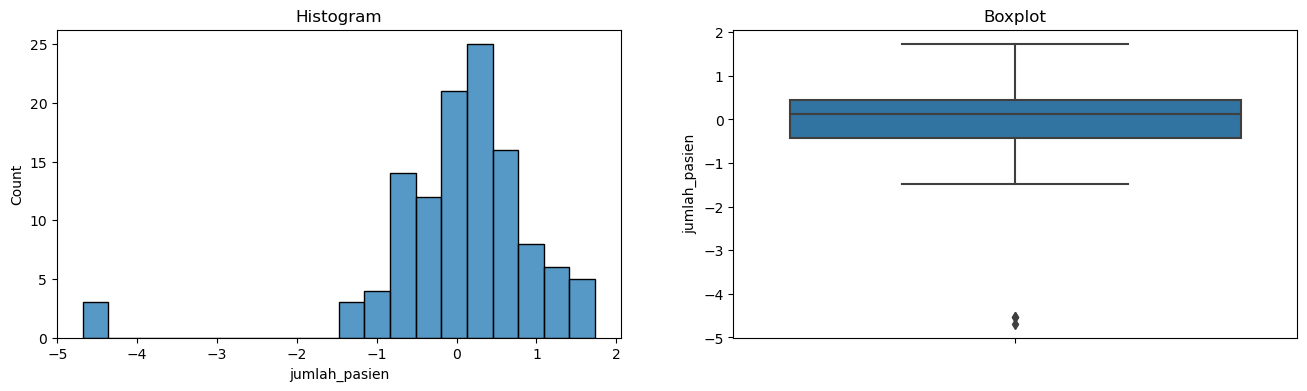

Skewness Value: -2.2819234262581554
Upper Boundary: 3.0129032853539375
Lower Boundary: -3.0129032853539375
% right end outliers: 0.0
% left end outliers: 2.564102564102564
Skewed Distribution
--------------------

Variable: avg_review


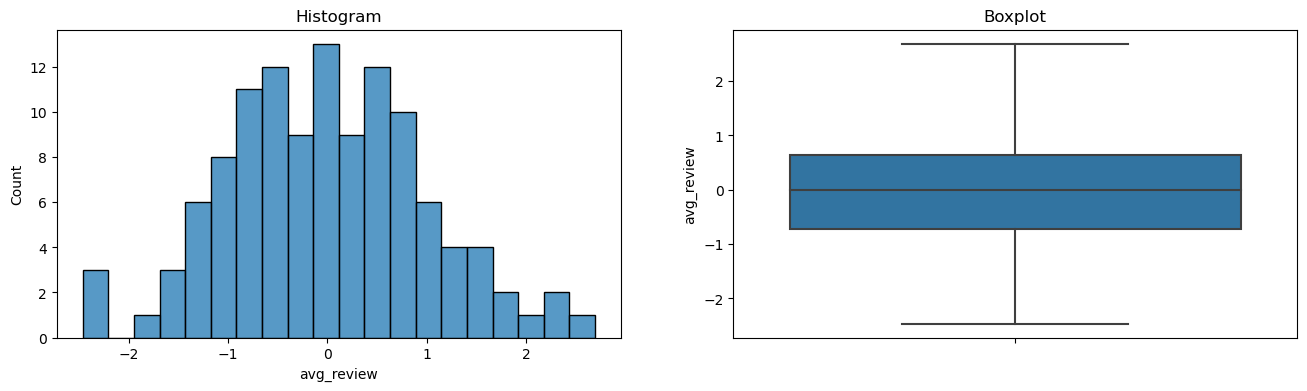

Skewness Value: 0.13699922921954158
Upper Boundary: 3.012903285353938
Lower Boundary: -3.012903285353937
% right end outliers: 0.0
% left end outliers: 0.0
Normal Distribution
--------------------

Variable: cogs


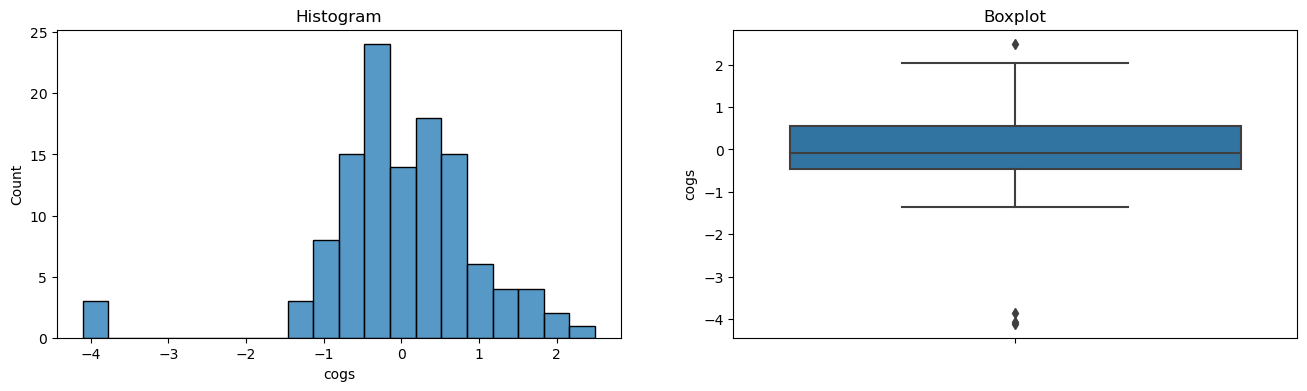

Skewness Value: -1.2170008258264136
Upper Boundary: 3.0129032853539366
Lower Boundary: -3.0129032853539366
% right end outliers: 0.0
% left end outliers: 2.564102564102564
Skewed Distribution
--------------------

Variable: total_revenue


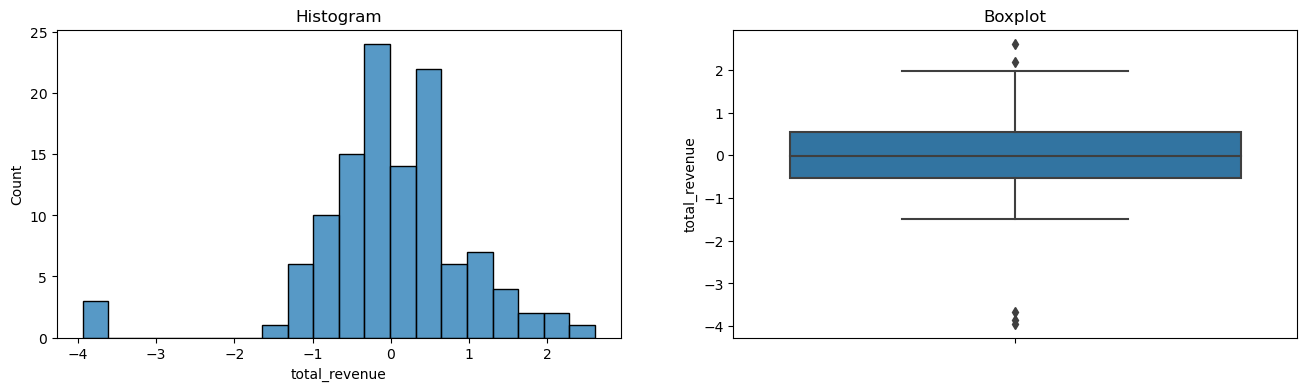

Skewness Value: -0.9821228120611336
Upper Boundary: 3.0129032853539384
Lower Boundary: -3.0129032853539384
% right end outliers: 0.0
% left end outliers: 2.564102564102564
Skewed Distribution
--------------------

Variable: total_profit


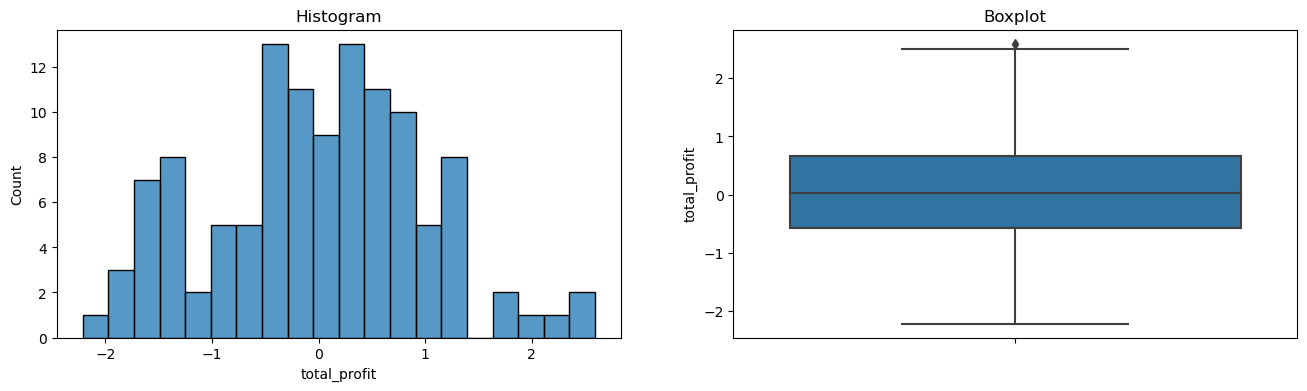

Skewness Value: 0.0352710814976428
Upper Boundary: 3.0129032853539384
Lower Boundary: -3.0129032853539384
% right end outliers: 0.0
% left end outliers: 0.0
Normal Distribution
--------------------

Variable: branch_name_RSMA


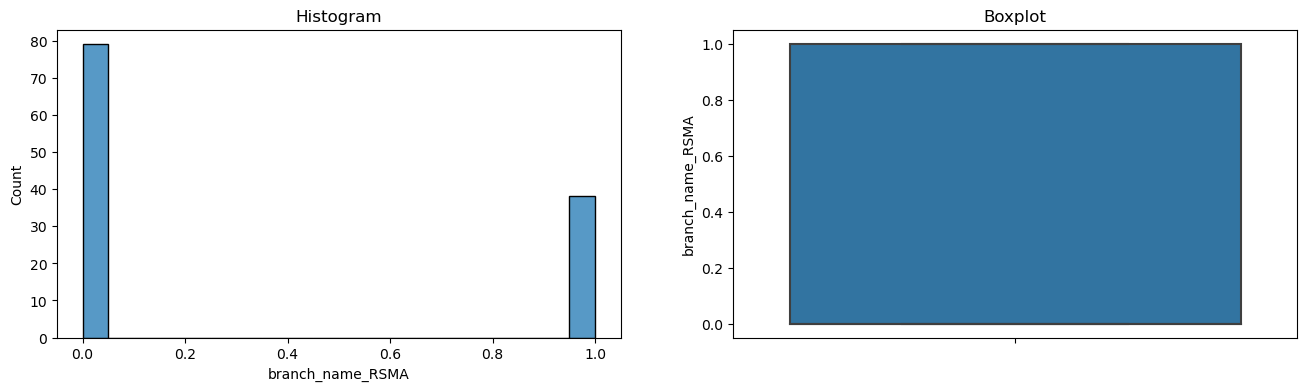

Skewness Value: 0.7580582837510714
Upper Boundary: 1.7357137433204437
Lower Boundary: -1.0861410937477942
% right end outliers: 0.0
% left end outliers: 0.0
Skewed Distribution
--------------------

Variable: branch_name_RSMD


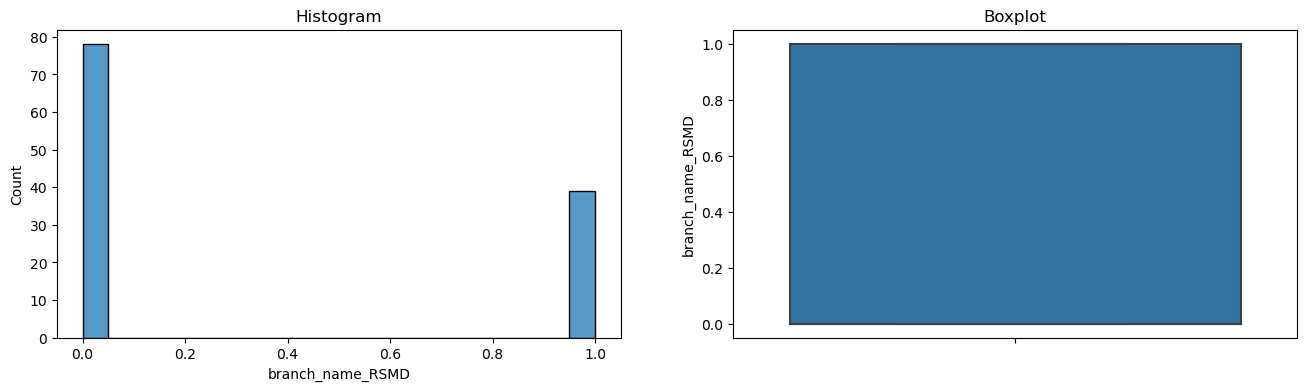

Skewness Value: 0.7163233157084863
Upper Boundary: 1.75362956275533
Lower Boundary: -1.0869628960886635
% right end outliers: 0.0
% left end outliers: 0.0
Skewed Distribution
--------------------

Variable: branch_name_RSMS


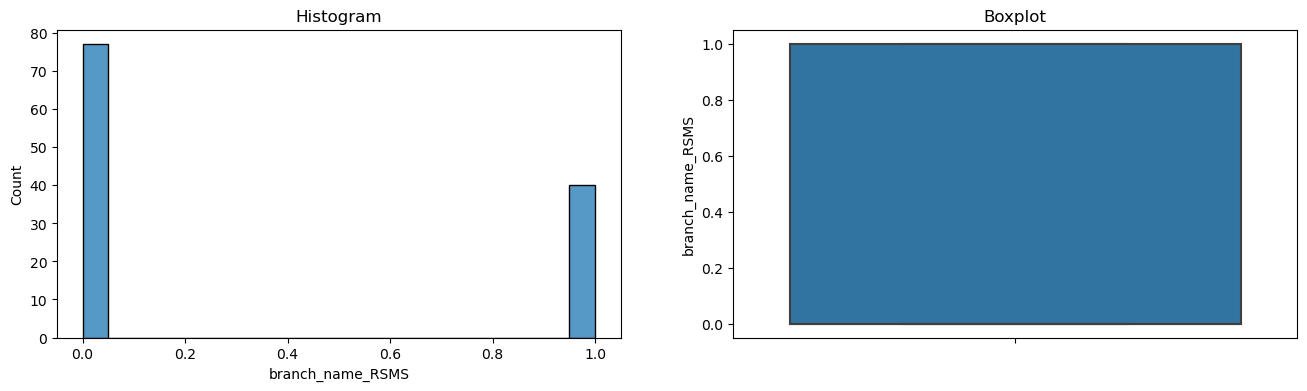

Skewness Value: 0.6753835071224168
Upper Boundary: 1.7710200545405104
Lower Boundary: -1.0872593707798268
% right end outliers: 0.0
% left end outliers: 0.0
Skewed Distribution
--------------------


In [34]:
variables = X_train

for variable in variables:
    print(f"\nVariable: {variable}")
    diagnostic_plots(X_train, variable)
    print('Skewness Value:', X_train[variable].skew())
    
    upper_boundary, lower_boundary = find_normal_boundaries(X_train, variable)
    print('Upper Boundary:', upper_boundary)
    print('Lower Boundary:', lower_boundary)

    outlier_right_tail, outlier_left_tail = percentage_outlier(X_train, variable, upper_boundary, lower_boundary)
    print(f"% right end outliers: {outlier_right_tail}")
    print(f"% left end outliers: {outlier_left_tail}")

    if (X_train[variable].skew() <= -0.5) | (X_train[variable].skew() >= 0.5):
        print('Skewed Distribution')
        print('-'*20)
    else:
        print('Normal Distribution')
        print('-'*20)


## 5.4 Outliers Handling

In [35]:
def outlier_analysis(dfml, col):
  skewness = dfml[col].skew()
  if skewness >= -0.5 and skewness <= 0.5:
    upper = dfml[col].mean() + 3 * dfml[col].std()
    lower = dfml[col].mean() - 3 * dfml[col].std()
  else:
    Q1 = dfml[col].quantile(0.25)
    Q3 = dfml[col].quantile(0.75)
    IQR = Q3 - Q1

    upper = Q3 + (1.5 * IQR)
    lower = Q1 - (1.5 * IQR)
    
  no_outliers = dfml[(dfml[col] >= lower) & (dfml[col] <= upper)]
  outliers = dfml[(dfml[col] > upper) | (dfml[col] < lower)]
  
  return outliers, no_outliers


In [36]:
columns = ['month', 'year', 'jumlah_pasien', 'avg_review', 'cogs', 'total_revenue', 'total_profit']

for col in columns:
    outliers, no_outliers = outlier_analysis(X_train, col)
    
    if len(outliers) > 0:
        print(f'Column name: {col}')
        print('Count of outliers:', len(outliers))
        print('Percentage of outliers:', (len(outliers) / len(X_train)) * 100, '%')
    else:
        print(f'Column name: {col}')
        print('No outliers found')
    
    print('-' * 20)


Column name: month
No outliers found
--------------------
Column name: year
No outliers found
--------------------
Column name: jumlah_pasien
Count of outliers: 3
Percentage of outliers: 2.564102564102564 %
--------------------
Column name: avg_review
No outliers found
--------------------
Column name: cogs
Count of outliers: 4
Percentage of outliers: 3.418803418803419 %
--------------------
Column name: total_revenue
Count of outliers: 5
Percentage of outliers: 4.273504273504273 %
--------------------
Column name: total_profit
No outliers found
--------------------


In [37]:
# capping outlier if exist and in large proportion
wins = Winsorizer(capping_method='iqr', tail='both', fold=1.5)
wins.fit(X_train)
X_train = wins.transform(X_train)

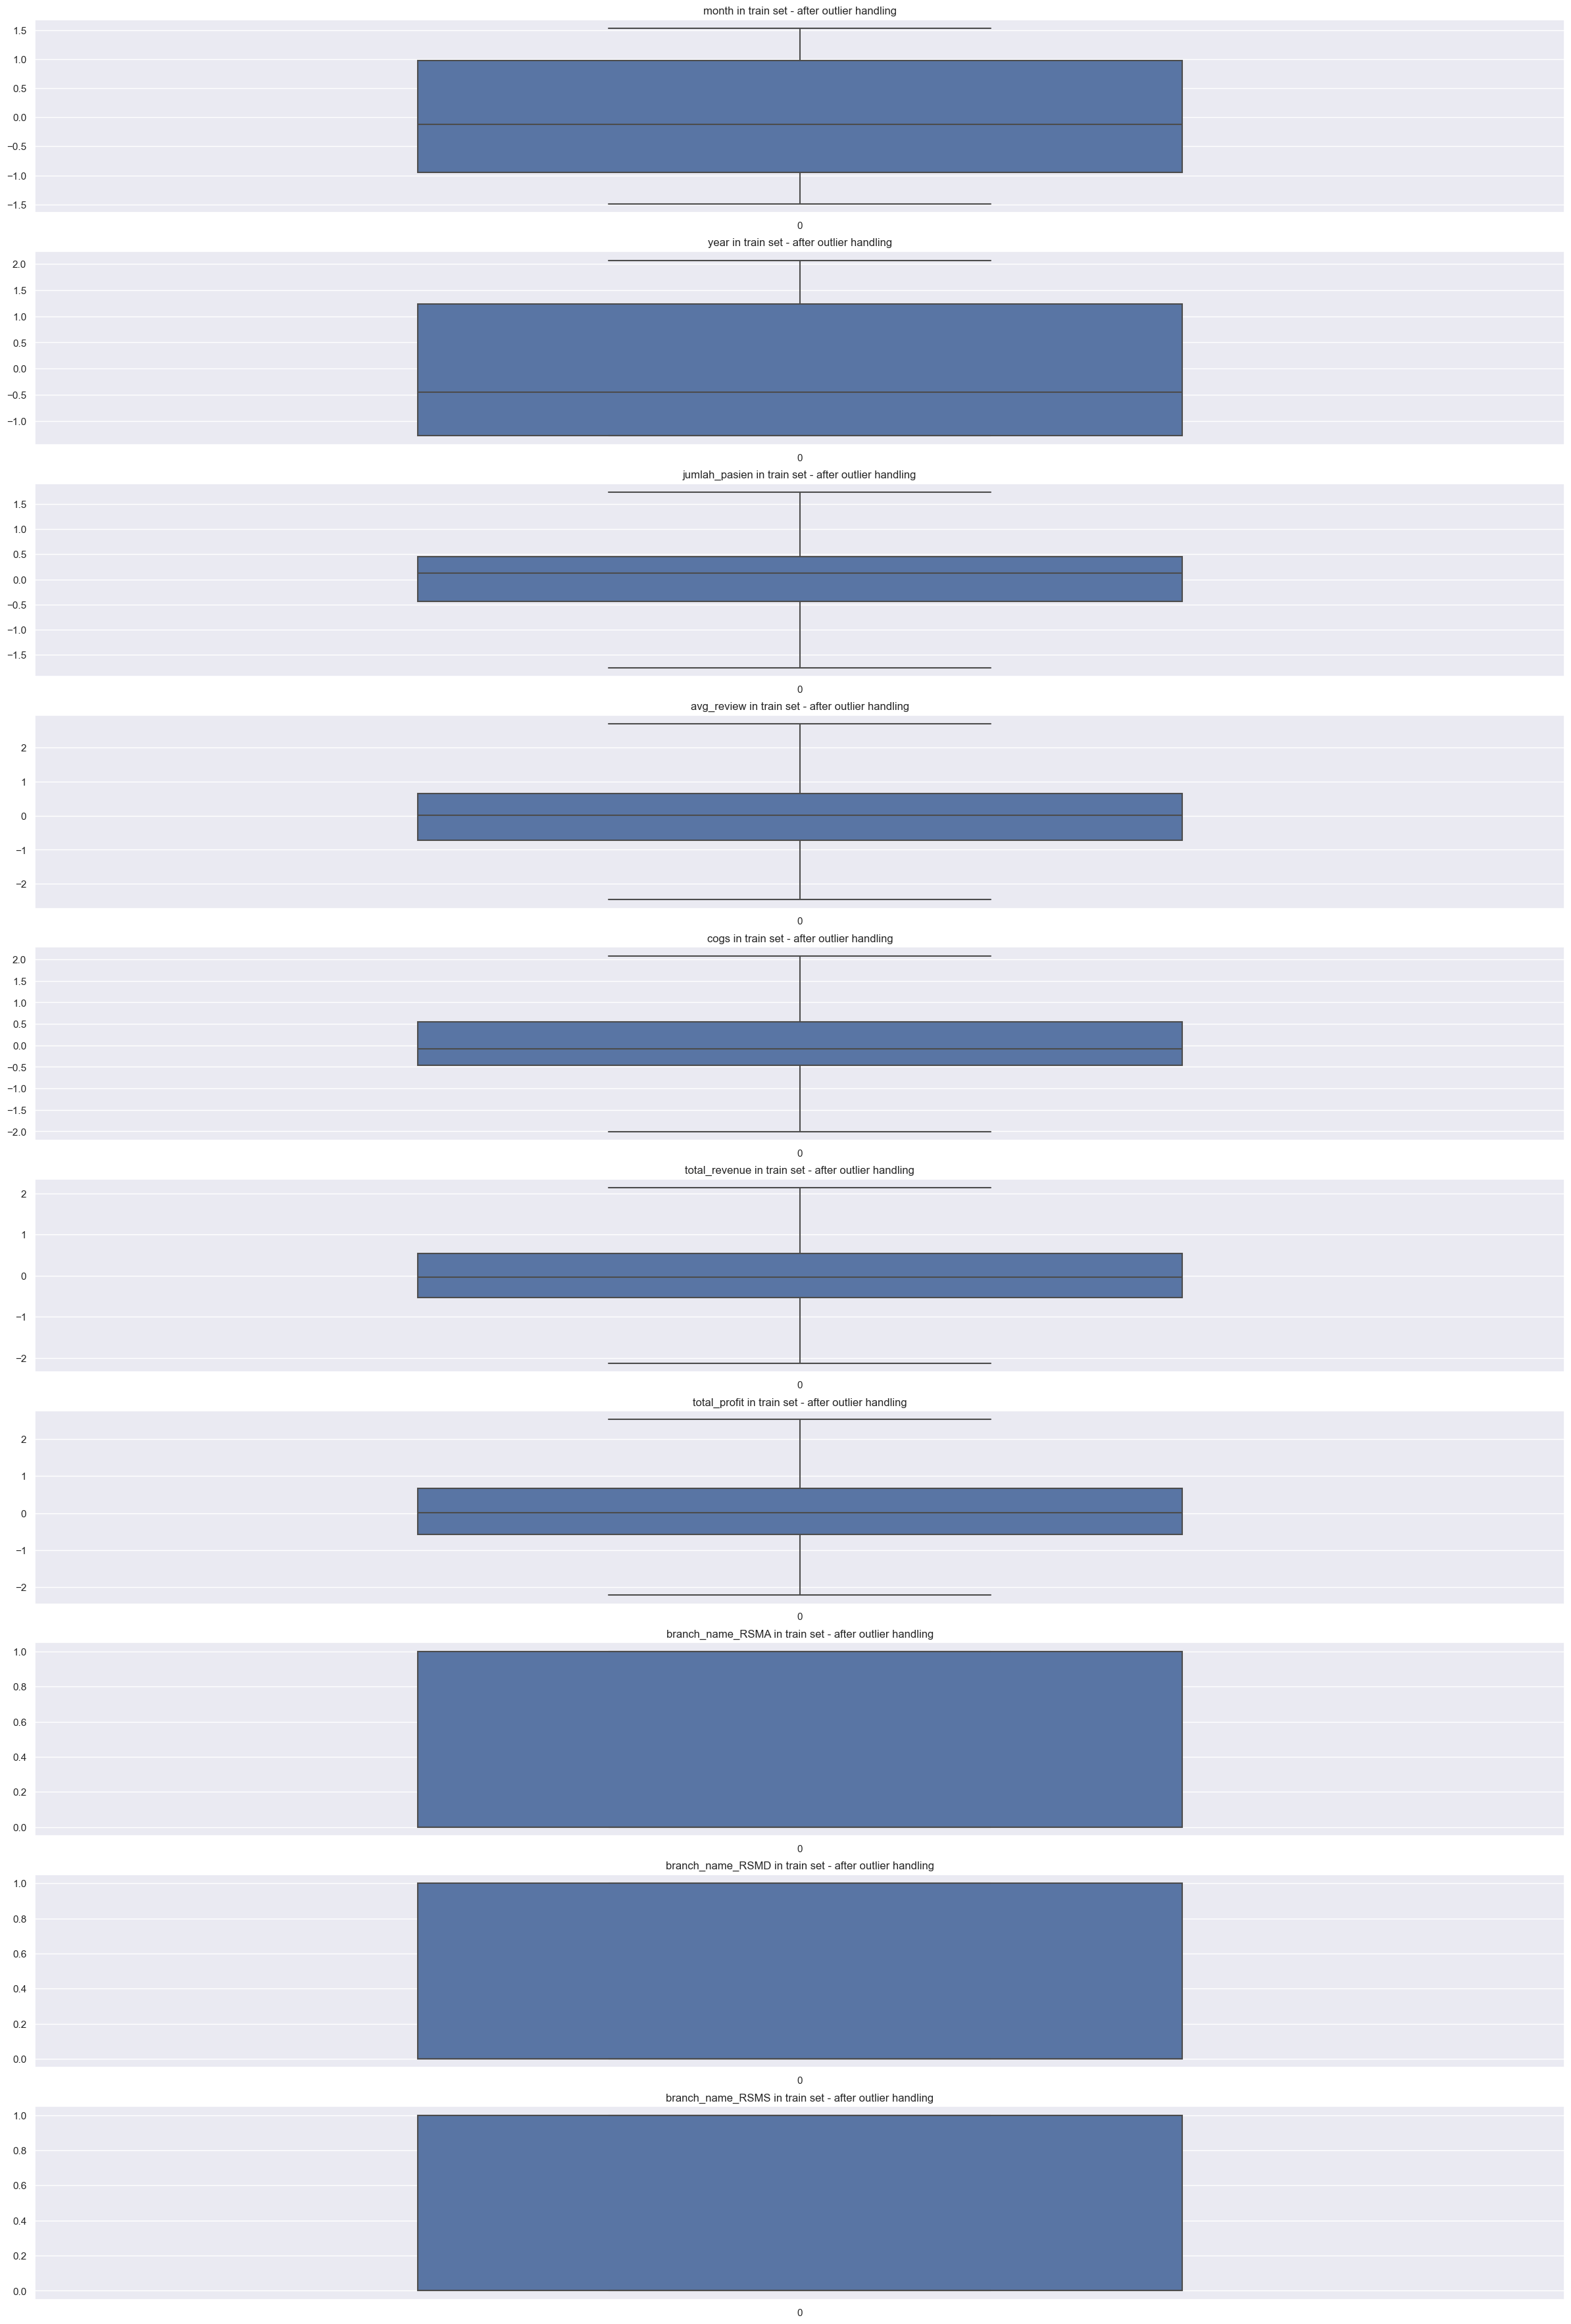

In [38]:
num = X_train
n = len(num.columns)
sns.set(font_scale=1)
fig, ax = plt.subplots(n, 1, figsize=(30, 45))
for i, col in enumerate(num.columns):
    sns.boxplot(ax=ax[i], data=X_train[col], width=0.50)
    ax[i].set_title(f'{col} in train set - after outlier handling')

plt.show()


## 5.5 Feature Selection

In [39]:
X_train_features = X_train.copy()

# Inisialisasi Selector
selector = SelectKBest(score_func=f_regression, k='all')

# Fit dan Transform Data
X_train_selected = selector.fit_transform(X_train, y_train)

# Melihat Skor Feature
feature_scores = selector.scores_

# Pemilihan Fitur Terbaik
selected_features = X_train.columns[selector.get_support()]

# Menampilkan hasil
print("Feature Scores:")
for feature, score in zip(X_train.columns, feature_scores):
    print(f"{feature}: {score}")

print("\nSelected Features:")
print(selected_features)


Feature Scores:
month: 1.5038976414221585
year: 8.677727079900814
jumlah_pasien: 65.62434085996557
avg_review: 44.29362191601485
cogs: 59.86823381770571
total_revenue: 100.34661348138526
total_profit: 264.839082347712
branch_name_RSMA: 1.1737770279017647
branch_name_RSMD: 0.44590188320943486
branch_name_RSMS: 0.16170432978126675

Selected Features:
Index(['month', 'year', 'jumlah_pasien', 'avg_review', 'cogs', 'total_revenue',
       'total_profit', 'branch_name_RSMA', 'branch_name_RSMD',
       'branch_name_RSMS'],
      dtype='object')


Berdasarkan hasil score tersebut maka diputuskan feature yang akan digunakan adalah jumlah_pasien, avg_review, cogs, total_revenue, dan total_profit karena feature tersebut merupakan feature dengan score yang tinggi.

#### VIF For Multicolinearity

In [40]:
# Ambil hanya variabel prediktor yang dipilih
X = X_train_features[['jumlah_pasien', 'avg_review', 'cogs', 'total_revenue', 'total_profit']]

# Hitung VIF untuk setiap variabel prediktor
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

        Variable          VIF
0  jumlah_pasien     4.912789
1     avg_review     1.097686
2           cogs  2583.793014
3  total_revenue  3644.616621
4   total_profit   188.503717


In [41]:
# Ambil hanya variabel prediktor yang dipilih
X = X_train_features[['jumlah_pasien', 'avg_review', 'total_revenue', 'total_profit']]

# Hitung VIF untuk setiap variabel prediktor
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

        Variable       VIF
0  jumlah_pasien  4.908777
1     avg_review  1.089004
2  total_revenue  8.253944
3   total_profit  2.755780


Dengan mempertimbangkan nilai VIF untuk menangani multicolinearitas pada feature, maka dipilih feature 'jumlah_pasien', 'avg_review', 'total_revenue', 'total_profit' sebagai feature yang akan digunakan dengan nilai VIF yang sudah tidak ada yang melebihi 10, sehingga sudah tidak terdapat multicolinearitas terhadap feature yang akan digunakan.

In [42]:
selected_features = ['jumlah_pasien', 'avg_review', 'total_revenue', 'total_profit']

# Filter data train dan test menggunakan fitur yang telah dipilih
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# vi. Model Definition


In [43]:
# Define Linear regression
linreg = LinearRegression()
svr = SVR()
knr = KNeighborsRegressor()
dectree = DecisionTreeRegressor()

# vii. Model Training


In [44]:
# Dictionary to hold models
models = {
    "Linear Regression": linreg,
    "Support Vector Regressor": svr,
    "K-Neighbors Regressor": knr,
    "Decision Tree Regressor": dectree}

## Cross Validation

In [45]:
# Function to train and evaluate models using cross-validation
def cross_val_evaluate(models, X, y, cv=5):
    results = {}
    for name, model in models.items():
        # Cross-validation
        scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
        mse_scores = -scores  # Negate to get positive MSE
        rmse_scores = np.sqrt(mse_scores)
        
        scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
        mae_scores = -scores  # Negate to get positive MAE
        
        scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
        r2_scores = scores
        
        results[name] = {
            'MSE': {
                'mean': mse_scores.mean()
            },
            'RMSE': {
                'mean': rmse_scores.mean()
            },
            'MAE': {
                'mean': mae_scores.mean()
            },
            'R²': {
                'mean': r2_scores.mean()
            }
        }
        
        # Print results
        print(f'{name} Cross-Validation MSE Mean: {results[name]["MSE"]["mean"]}')
        print(f'{name} Cross-Validation RMSE Mean: {results[name]["RMSE"]["mean"]}')
        print(f'{name} Cross-Validation MAE Mean: {results[name]["MAE"]["mean"]}')
        print(f'{name} Cross-Validation R² Mean: {results[name]["R²"]["mean"]}')
        
    return results

# Perform cross-validation
results = cross_val_evaluate(models, X_train_selected, y_train, cv=5)


Linear Regression Cross-Validation MSE Mean: 0.00017046371238811018
Linear Regression Cross-Validation RMSE Mean: 0.012311377986375854
Linear Regression Cross-Validation MAE Mean: 0.006554493231854664
Linear Regression Cross-Validation R² Mean: 0.990017461880871
Support Vector Regressor Cross-Validation MSE Mean: 0.004132262947441936
Support Vector Regressor Cross-Validation RMSE Mean: 0.06311778686574046
Support Vector Regressor Cross-Validation MAE Mean: 0.04216541015105206
Support Vector Regressor Cross-Validation R² Mean: 0.7560283168824221
K-Neighbors Regressor Cross-Validation MSE Mean: 0.0016878415480433774
K-Neighbors Regressor Cross-Validation RMSE Mean: 0.04012373412120181
K-Neighbors Regressor Cross-Validation MAE Mean: 0.027866328257053947
K-Neighbors Regressor Cross-Validation R² Mean: 0.9027484632265826
Decision Tree Regressor Cross-Validation MSE Mean: 0.004543971207480723
Decision Tree Regressor Cross-Validation RMSE Mean: 0.06689773765238674
Decision Tree Regressor Cro

In [46]:
# Pilih model terbaik berdasarkan hasil cross-validation dengan nilai MAE terendah
best_model_name = min(results, key=lambda x: np.mean(results[x]['MAE']['mean']))  
best_model = models[best_model_name]
print(f"Best Model: {best_model_name}")

Best Model: Linear Regression


In [47]:
# Pilih model terbaik berdasarkan hasil cross-validation dengan nilai MSE terendah
best_model_name = min(results, key=lambda x: np.mean(results[x]['MSE']['mean']))  
best_model = models[best_model_name]
print(f"Best Model: {best_model_name}")

Best Model: Linear Regression


In [48]:
# Pilih model terbaik berdasarkan hasil cross-validation dengan nilai RMSE terendah
best_model_name = min(results, key=lambda x: np.mean(results[x]['RMSE']['mean']))  
best_model = models[best_model_name]
print(f"Best Model: {best_model_name}")

Best Model: Linear Regression


In [49]:
X_train_selected

,jumlah_pasien,avg_review,total_revenue,total_profit
0,0.130249,1.024197,-0.239086,-0.095764
1,-1.072841,-2.293182,-1.223222,-1.697188
2,0.771897,0.542531,1.348019,2.492014
3,-0.671811,1.047288,-0.271298,-0.577541
4,-1.754592,0.077474,-2.135140,-1.902163
...,...,...,...,...
112,1.172927,-1.149760,2.141965,2.526975
113,0.370867,-0.517262,0.333491,-0.760451
114,-0.270781,1.723411,-0.290526,0.304911
115,0.210455,0.775059,-0.462667,-0.278795


In [50]:
# Evaluasi model terbaik pada test set
best_model.fit(X_train_selected, y_train)
y_test_pred = best_model.predict(X_test_selected)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("Test Set Evaluation:")
print(f"Test MSE: {mse_test}")
print(f"Test RMSE: {rmse_test}")
print(f"Test MAE: {mae_test}")
print(f"Test R²: {r2_test}")


Test Set Evaluation:
Test MSE: 3.181437499088638e-05
Test RMSE: 0.005640423298909966
Test MAE: 0.00470213683326266
Test R²: 0.9957070904648211


Hasil evaluasi menunjukkan bahwa model Linear Regression adalah model yang terbaik untuk digunakan dalam pemodelan machine learning ini. Berikut merupakan ringkasan dari hasil evaluasi terhadap validation set dan test set untuk model Linear Regression:

Training Set:
- Linear Regression Cross-Validation MSE Mean: 0.00017046371238811018
- Linear Regression Cross-Validation RMSE Mean: 0.012311377986375854
- Linear Regression Cross-Validation MAE Mean: 0.006554493231854664
- Linear Regression Cross-Validation R² Mean: 0.990017461880871

Hasil evaluasi cross-validation pada training set menunjukkan bahwa model Linear Regression memiliki performa yang sangat baik dengan nilai MSE, RMSE, dan MAE yang rendah. Nilai R² yang mendekati 1 (0.99) mengindikasikan bahwa model mampu menjelaskan 99% variabilitas dari data training, yang menandakan bahwa model ini sangat akurat dalam memprediksi data training.

Test Set Evaluation:
- Linear Regression Test MSE: 3.181437499088638e-05
- Linear Regression Test RMSE: 0.005640423298909966
- Linear Regression Test MAE: 0.00470213683326266
- Linear Regression Test R²: 0.9957070904648211

Evaluasi pada test set juga menunjukkan hasil yang sangat baik. Nilai MSE, RMSE, dan MAE yang lebih rendah dibandingkan hasil pada training set menunjukkan bahwa model tidak mengalami overfitting dan mampu melakukan generalisasi dengan baik pada data baru. Nilai R² yang sangat tinggi (0.9957) menunjukkan bahwa model dapat menjelaskan sekitar 99.57% variabilitas dari data test, yang berarti model ini sangat kuat dalam memprediksi data test.

**Ringkasan:**
- **Kemampuan Generalisasi**: Performa model pada training set dan test set menunjukkan bahwa model Linear Regression ini memiliki kemampuan generalisasi yang sangat baik. Tidak ada indikasi overfitting atau underfitting yang signifikan.
- **Kesalahan Prediksi**: Nilai MAE dan RMSE yang rendah pada kedua set data menunjukkan bahwa kesalahan prediksi dari model ini sangat kecil, sehingga prediksi yang dihasilkan oleh model sangat dekat dengan nilai sebenarnya.
- **R² Score yang Tinggi**: Nilai R² yang tinggi di kedua set data menunjukkan bahwa model ini sangat efektif dalam menjelaskan variabilitas dari data, sehingga model ini sangat cocok untuk digunakan dalam pemodelan machine learning pada data ini.

# viii. Model Boosting

## Gradient Boosting Regressor

In [51]:
# Initialize the model
gbr = GradientBoostingRegressor(random_state=0)

# Train the model
gbr.fit(X_train_selected, y_train)

# Predict on the test set
y_test_pred_gbr = gbr.predict(X_test_selected)

# Evaluate the model
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_test_pred_gbr))
mae_gbr = mean_absolute_error(y_test, y_test_pred_gbr)
r2_gbr = r2_score(y_test, y_test_pred_gbr)

print(f'Gradient Boosting Test RMSE: {rmse_gbr}')
print(f'Gradient Boosting Test MAE: {mae_gbr}')
print(f'Gradient Boosting Test R²: {r2_gbr}')


Gradient Boosting Test RMSE: 0.01210605001755939
Gradient Boosting Test MAE: 0.009357545385025973
Gradient Boosting Test R²: 0.9802242360861348


## XGB Regressor

In [52]:
# Initialize the model
xgbr = XGBRegressor(random_state=0)

# Train the model
xgbr.fit(X_train_selected, y_train)

# Predict on the validation set
y_test_pred_xgbr = xgbr.predict(X_test_selected)

# Evaluate the model
rmse_xgbr = np.sqrt(mean_squared_error(y_test, y_test_pred_xgbr))
mae_xgbr = mean_absolute_error(y_test, y_test_pred_xgbr)
r2_xgbr = r2_score(y_test, y_test_pred_xgbr)

print(f'XGBoost Validation RMSE: {rmse_xgbr}')
print(f'XGBoost Validation MAE: {mae_xgbr}')
print(f'XGBoost Validation R²: {r2_xgbr}')


XGBoost Validation RMSE: 0.019066099282611396
XGBoost Validation MAE: 0.015086688210988072
XGBoost Validation R²: 0.9509485363960266


## LGBM Regressor

In [53]:
# Initialize the model
lgbmr = LGBMRegressor(random_state=0, verbose=-1)

# Train the model
lgbmr.fit(X_train_selected, y_train)

# Predict on the validation set
y_test_pred_lgbmr = lgbmr.predict(X_test_selected)

# Evaluate the model
rmse_lgbmr = np.sqrt(mean_squared_error(y_test, y_test_pred_lgbmr))
mae_lgbmr = mean_absolute_error(y_test, y_test_pred_lgbmr)
r2_lgbmr = r2_score(y_test, y_test_pred_lgbmr)

print(f'LightGBM Validation RMSE: {rmse_lgbmr}')
print(f'LightGBM Validation MAE: {mae_lgbmr}')
print(f'LightGBM Validation R²: {r2_lgbmr}')


LightGBM Validation RMSE: 0.030721885220790092
LightGBM Validation MAE: 0.023411507160836058
LightGBM Validation R²: 0.8726426348693439


## Best Model on Boosted Model

In [54]:
# Dictionary to hold test results
test_results_boosting = {
    "Gradient Boosting": {"RMSE": rmse_gbr, "MAE": mae_gbr, "R²": r2_gbr},
    "XGBoost": {"RMSE": rmse_xgbr, "MAE": mae_xgbr, "R²": r2_xgbr},
    "LightGBM": {"RMSE": rmse_lgbmr, "MAE": mae_lgbmr, "R²": r2_lgbmr}
}

# Select the best model based on test RMSE
best_model_name_boosting = min(test_results_boosting, key=lambda x: test_results_boosting[x]["RMSE"])
best_model_boosting = {
    "Gradient Boosting": gbr,
    "XGBoost": xgbr,
    "LightGBM": lgbmr
}[best_model_name_boosting]

print(f'Best Boosting Model: {best_model_name_boosting}')

# Evaluate the best model on the test set
y_test_pred_boosting = best_model_boosting.predict(X_test_selected)
rmse_test_boosting = np.sqrt(mean_squared_error(y_test, y_test_pred_boosting))
mae_test_boosting = mean_absolute_error(y_test, y_test_pred_boosting)
r2_test_boosting = r2_score(y_test, y_test_pred_boosting)

print(f'Test RMSE: {rmse_test_boosting}')
print(f'Test MAE: {mae_test_boosting}')
print(f'Test R²: {r2_test_boosting}')


Best Boosting Model: Gradient Boosting
Test RMSE: 0.01210605001755939
Test MAE: 0.009357545385025973
Test R²: 0.9802242360861348


Tidak terdapat improving dari base model yang digunakan dibandingkan dengan model boosting, sehingga diputuskan untuk memakai linear regression sebagai model yang selanjutnya akan digunakan.


# ix. Hyper Paramater Tuning

## GridSearchCV

In [55]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

# Initialize the GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=0)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, 
                           scoring='neg_mean_absolute_error', cv=5, 
                           n_jobs=-1, verbose=2)

# Fit GridSearchCV on the training data
grid_search.fit(X_train_selected, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_gbr = grid_search.best_estimator_

print(f'Best Parameters: {best_params}')

# Evaluate the best model on the training set
y_train_pred_best_gbr = best_gbr.predict(X_train_selected)
rmse_train_best_gbr = np.sqrt(mean_squared_error(y_train, y_train_pred_best_gbr))
mae_train_best_gbr = mean_absolute_error(y_train, y_train_pred_best_gbr)
r2_train_best_gbr = r2_score(y_train, y_train_pred_best_gbr)

print(f'training RMSE: {rmse_train_best_gbr}')
print(f'training MAE: {mae_train_best_gbr}')
print(f'training R²: {r2_train_best_gbr}')

# Evaluate the best model on the test set
y_test_pred_best_gbr = best_gbr.predict(X_test_selected)
rmse_test_best_gbr = np.sqrt(mean_squared_error(y_test, y_test_pred_best_gbr))
mae_test_best_gbr = mean_absolute_error(y_test, y_test_pred_best_gbr)
r2_test_best_gbr = r2_score(y_test, y_test_pred_best_gbr)

print(f'Test RMSE: {rmse_test_best_gbr}')
print(f'Test MAE: {mae_test_best_gbr}')
print(f'Test R²: {r2_test_best_gbr}')


Fitting 5 folds for each of 729 candidates, totalling 3645 fits


Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300, 'subsample': 0.8}
training RMSE: 0.0016639990514262552
training MAE: 0.0012881417501793512
training R²: 0.9998430878063516
Test RMSE: 0.012263859784308469
Test MAE: 0.009180273218964564
Test R²: 0.9797052972892438


## RandomizedSearchCV

In [57]:
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

# Initialize the GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=0)

# Initialize GridSearchCV
random_search = RandomizedSearchCV(estimator=gbr, param_distributions=param_grid,
                                   n_iter=100, scoring='neg_mean_absolute_error',
                                   cv=5, n_jobs=-1, random_state=0, verbose=2)

# Fit GridSearchCV on the training data
random_search.fit(X_train_selected, y_train)

# Get the best parameters and the best estimator
best_params = random_search.best_params_
best_gbr_random = random_search.best_estimator_

print(f'Best Parameters: {best_params}')

# Evaluate the best model on the training set
y_train_pred_best_gbr_random = best_gbr_random.predict(X_train_selected)
rmse_train_best_gbr_random = np.sqrt(mean_squared_error(y_train, y_train_pred_best_gbr_random))
mae_train_best_gbr_random = mean_absolute_error(y_train, y_train_pred_best_gbr_random)
r2_train_best_gbr_random = r2_score(y_train, y_train_pred_best_gbr_random)

print(f'training RMSE: {rmse_train_best_gbr_random}')
print(f'training MAE: {mae_train_best_gbr_random}')
print(f'training R²: {r2_train_best_gbr_random}')

# Evaluate the best model on the test set
y_test_pred_best_gbr_random = best_gbr_random.predict(X_test_selected)
rmse_test_best_gbr_random = np.sqrt(mean_squared_error(y_test, y_test_pred_best_gbr_random))
mae_test_best_gbr_random = mean_absolute_error(y_test, y_test_pred_best_gbr_random)
r2_test_best_gbr_random = r2_score(y_test, y_test_pred_best_gbr_random)

print(f'Test RMSE: {rmse_test_best_gbr_random}')
print(f'Test MAE: {mae_test_best_gbr_random}')
print(f'Test R²: {r2_test_best_gbr_random}')


Fitting 5 folds for each of 100 candidates, totalling 500 fits


Best Parameters: {'subsample': 0.8, 'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.05}
training RMSE: 0.00205276827834728
training MAE: 0.0016433329088276576
training R²: 0.9997612021562718
Test RMSE: 0.011648308902925918
Test MAE: 0.009101478434303208
Test R²: 0.981691443720057


## viii. Pemilihan Model

Berdasarkan hasil yang diberikan, kita dapat membandingkan kinerja tiga model dengan metrik yang berbeda: RMSE (Root Mean Squared Error), MAE (Mean Absolute Error), dan R² (R-squared) pada set validasi dan uji.

### Hasil Model:

1. **Base Model Linear Regression:**
    - **Test:**
        - Test RMSE: 0.005640423298909966
        - Test MAE: 0.00470213683326266
        - Test R²: 0.9957070904648211

2. **GridSearchCV:**
    - **Training:**
        - RMSE: 0.0016639990514262552
        - MAE: 0.0012881417501793512
        - R²: 0.9998430878063516   
    - **Test:**
        - RMSE: 0.012263859784308469
        - MAE: 0.009180273218964564
        - R²: 0.9797052972892438

3. **RandomizedSearchCV:**
    - **Training:**
        - RMSE: 0.00205276827834728
        - MAE: 0.0016433329088276576
        - R²: 0.9997612021562718
    - **Test:**
        - RMSE: 0.011648308902925918
        - MAE: 0.009101478434303208
        - R²: 0.981691443720057

### Kesimpulan:

#### **1. Base Model Linear Regression:**
- Model ini memiliki performa yang cukup baik dengan nilai R² yang tinggi baik pada training maupun test set, yang menunjukkan bahwa model mampu menjelaskan variabilitas data dengan baik. Nilai RMSE dan MAE juga lebih rendah dibandingkan dengan model yang lain.
- **Overfitting Indicator:** Tidak ada indikasi overfitting yang jelas karena performa pada training dan test set relatif konsisten.

#### **2. GridSearchCV:**
- Model ini menunjukkan performa yang sangat baik pada training set dengan nilai R² yang mendekati 1 dan nilai error yang sangat rendah. Namun, performa menurun pada test set, dengan peningkatan RMSE dan MAE, serta penurunan R².
- **Overfitting Indicator:** Ada indikasi overfitting karena performa pada training set sangat baik dibandingkan dengan test set.

#### **3. RandomizedSearchCV:**
- Model RandomizedSearchCV juga menunjukkan kinerja yang sangat baik pada data training, namun sedikit lebih baik dibandingkan GridSearchCV pada data uji.
- **Overfitting Indicator:** Perbedaan antara metrik training dan test juga menunjukkan sedikit indikasi overfitting. Meskipun ada indikasi overfitting, performa model ini lebih stabil dibandingkan GridSearchCV.

### Ringkasan:

1. **Base Model Linear Regression:** Menunjukkan performa yang sangat baik pada test set tanpa indikasi overfitting, sehingga dapat digunakan untuk prediksi pada data baru.

2. **GridSearchCV:** Menunjukkan performa yang sangat baik pada training set namun sedikit lebih rendah pada test set, dengan indikasi overfitting yang lebih jelas.

3. **RandomizedSearchCV:** Juga menunjukkan performa yang sangat baik pada training dan test set, dengan sedikit indikasi overfitting, tetapi performanya pada test set sedikit lebih baik daripada GridSearchCV.

**Rekomendasi:**
- **Base Model Linear Regression** adalah pilihan terbaik untuk digunakan jika prioritas adalah menghindari overfitting dan memastikan model yang kuat dan andal pada data baru.
- Jika tuning parameter tambahan diperlukan, **RandomizedSearchCV** bisa dipertimbangkan karena menunjukkan performa yang sangat baik dengan sedikit indikasi overfitting dibandingkan GridSearchCV.

### Keputusan:
Berdasarkan hasil di atas, model **Base Model Linear Regression** adalah pilihan yang paling tepat untuk digunakan karena kinerjanya yang stabil dan akurat baik pada data training maupun data uji.

**Detail Model Terbaik (Linear Regression):**

**Test:**
- Test RMSE: 0.005640423298909966
- Test MAE: 0.00470213683326266
- Test R²: 0.9957070904648211

# x. Model Saving

In [58]:
import pickle
model_filename = "model_linear.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

# Pipeline

In [78]:
data = pd.read_csv("cleaned_data.csv")
# Mengonversi kolom date_out menjadi tipe data datetime
dfeda['date_out'] = pd.to_datetime(dfeda['date_out'])

# Menambahkan kolom bulan dan tahun
dfeda['month'] = dfeda['date_out'].dt.month
dfeda['year'] = dfeda['date_out'].dt.year

# Memetakan nilai-nilai review ke skala yang diinginkan
review_mapping = {
    'Sangat Tidak Puas': 1,
    'Tidak Puas': 2,
    'Cukup Puas': 3,
    'Puas': 4,
    'Sangat Puas': 5
}
dfeda['review_value'] = dfeda['review_name'].map(review_mapping)
dfeda['name_gender_age'] = dfeda['patient_name'] + '_' + dfeda['gender'] + '_' + dfeda['age'].astype(str)
# Mengelompokkan dan menghitung total_pasien, total_revenue, dan total_profit
new_df = dfeda.groupby(['branch_name', 'month', 'year']).agg(
    jumlah_pasien=('name_gender_age', 'nunique'),
    avg_review=('review_value', 'mean'),
    cogs=('cogs', 'sum'),
    total_revenue=('revenue', 'sum'),
    total_profit=('profit', 'sum')
).reset_index()

new_df

,branch_name,month,year,jumlah_pasien,avg_review,cogs,total_revenue,total_profit
0,RSMA,1,2020,73,2.925926,618794664,704880000.0,86085336.0
1,RSMA,1,2021,70,3.137255,577144399,620665000.0,43520601.0
2,RSMA,1,2022,78,2.929577,573240080,621825000.0,48584920.0
3,RSMA,1,2023,54,3.000000,391419494,440955000.0,49535506.0
4,RSMA,1,2024,6,3.000000,56732879,70240000.0,13507121.0
...,...,...,...,...,...,...,...,...
142,RSMS,11,2023,59,2.791667,409660260,433070000.0,23409740.0
143,RSMS,12,2020,57,3.269231,520486164,579870000.0,59383836.0
144,RSMS,12,2021,66,3.125000,479313670,512980000.0,33666330.0
145,RSMS,12,2022,69,3.266667,456831916,471050000.0,14218084.0


In [79]:
# Normalisasi menggunakan MinMaxScaler
scaler_jumlah_pasien = MinMaxScaler()
scaler_total_profit = MinMaxScaler()
scaler_avg_review = MinMaxScaler()

# Fit dan transformasi setiap fitur
new_df['norm_jumlah_pasien'] = scaler_jumlah_pasien.fit_transform(new_df[['jumlah_pasien']])
new_df['norm_total_profit'] = scaler_total_profit.fit_transform(new_df[['total_profit']])
new_df['norm_avg_review'] = scaler_avg_review.fit_transform(new_df[['avg_review']])
new_df['score'] = (new_df['norm_jumlah_pasien']*0.2) + (new_df['norm_total_profit']*0.45) + (new_df['norm_avg_review']*0.35)

In [80]:
# Menentukan fitur dan target
X = new_df[['jumlah_pasien', 'avg_review', 'total_revenue', 'total_profit']]
y = new_df['score']

# Pipeline untuk preprocessing
# Fitur numerik: melakukan standard scaling
numeric_features = ['jumlah_pasien', 'avg_review', 'total_revenue', 'total_profit']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# 8. Pipeline utama: preprocessing dan model
pipeline = Pipeline(steps=[
    ('preprocessor', numeric_transformer),
    ('feature_selection', SelectFromModel(LinearRegression())),
    ('polynomial_features', PolynomialFeatures(degree=2)),
    ('regressor', LinearRegression())
])

# 9. Split data menjadi train dan test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 10. Training pipeline pada data train
pipeline.fit(X_train, y_train)

# 11. Evaluasi model
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

# 12. Simpan model ke file pickle
model_filename = "model_pipeline.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(pipeline, file)

Mean Squared Error: 0.00034610945143974343
Root Mean Squared Error: 0.018604017078032997
Mean Absolute Error: 0.016252550580098887
R-squared: 0.9532973203236945
